<a href="https://colab.research.google.com/github/vignesh99/CS6300-Speech-Technology/blob/master/HMMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
                                    #Get data files onto root
%cd
from google.colab import drive
drive.mount('/content/gdrive')
!cp -avr /content/gdrive/My\ Drive/HMM_IsoData/1 /root
!cp -avr /content/gdrive/My\ Drive/HMM_IsoData/2 /root
!cp -avr /content/gdrive/My\ Drive/HMM_IsoData/3 /root
!cp -avr /content/gdrive/My\ Drive/HMM_IsoData/6 /root
!cp -avr /content/gdrive/My\ Drive/HMM_IsoData/7 /root
!cp -avr /content/gdrive/My\ Drive/ctsHMM /root
!cp -avr /content/gdrive/My\ Drive/cenKM48.pkl /root
!ls

/root
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
'/content/gdrive/My Drive/HMM_IsoData/1' -> '/root/1'
'/content/gdrive/My Drive/HMM_IsoData/2' -> '/root/2'
'/content/gdrive/My Drive/HMM_IsoData/3' -> '/root/3'
'/content/gdrive/My Drive/HMM_IsoData/6' -> '/root/6'
'/content/gdrive/My Drive/HMM_IsoData/7' -> '/root/7'
'/content/gdrive/My Drive/ctsHMM' -> '/root/ctsHMM'
'/content/gdrive/My Drive/ctsHMM/test' -> '/root/ctsHMM/test'
'/content/gdrive/My Drive/ctsHMM/test/3.mfcc' -> '/root/ctsHMM/test/3.mfc

In [55]:
                                    #Import required libraries
from pylab import *
import os                           #Going through folders
from scipy.cluster.vq import kmeans2
from google.colab import files
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.special import softmax
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

In [8]:
                                    #Use pkl to store model
!pip install pickle-mixin
from pickle import dump
from pickle import load
                                    #Load the previous Kmeans model
cenKM = load(open('cenKM48.pkl', 'rb'))

  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-cp36-none-any.whl size=5998 sha256=e8c524cd1d6b37f6308c54f0bec87a230376d5f627c4bf742142da8ce45b3a4b
  Stored in directory: /root/.cache/pip/wheels/cd/05/42/71de70fa36b9cbb7657bb5793a16f8028c1cdc1bdd3b8e1ac3
Successfully built pickle-mixin


**Discete HMMs**

In [49]:
def fileTofeature(fileMfcc) :
                                    #Convert features from file into array
    features = np.genfromtxt(fileMfcc,delimiter='\n',dtype=str)
    Nc,Nf = features[0].split(" ")
    Nc = int(Nc)
    Nf = int(Nf)
    features = np.genfromtxt(features[1:],delimiter=' ',dtype=str)
    features = features.astype(float)
                                    
    return Nf,features


In [48]:
                                    #Give the file with sequences for training data
def trainCentre(Nclust=48,folders=None) :
    if folders is None :            #Go through all digits
        folders = array(["1","2","3","6","7"])

    ind = []                     #All digits total vector numbers
    ind.append([0,0])            #Inital values
    Nwin = []                       #No. of vectors in each train file
    count = 0
    for word in folders :
                                    #Go through required folders
        for subdir, dirs, files in os.walk(word):
            dirname = subdir.split(os.path.sep)[-1]
            print('Directory:', dirname)
            if dirname == "train":
                for f in files:
                    if f.endswith('.mfcc'):
                                    #Copy file (mfcc) to root and perform K-means
                        !cp -avr /root/$word/train/$f /root
                        foo,temp = fileTofeature(f)
                                    #Concatenate training feature vectors
                        if count == 0 :
                            features = temp
                            Nwin.append(foo)
                        else :
                            features = np.concatenate((features,temp))
                            Nwin.append(foo+Nwin[-1])
                        !rm $f
                        count+=1
        ind.append([len(Nwin),Nwin[-1]])
                                    #Apply K-means on the vectors
    trainKM = KMeans(n_clusters=Nclust)
    trainKM.fit(features)
                                    #Get Nwin in required format
    ind = array(ind)
    Nwin = array(Nwin)
    for i in range(5) :
        Nwin[ind[i,0]:ind[i+1,0]] -=  ind[i,1]

    return Nwin,features,trainKM,ind


In [46]:
def seqDwnld(seq,fileWord) :
    with open(fileWord,"w") as f:
        f.write("\n".join(" ".join(map(str, line)) for line in seq))

    return None

In [47]:
                                    #Give the file with sequences for training data
def trainSeq(Nwin,features,trainKM,fileWord="check.txt") :
    seq = []
    count = 0
                                    #Go through required folders
    for i in range(0,len(Nwin)) :
                                    #Get each features from all-features-array
        if i != 0:
            temp = features[Nwin[i-1]:Nwin[i]]
        else : 
            temp = features[:Nwin[0]]
                                    #Perform Kmeans on predefined centres
        label = trainKM.predict(temp)
        seq.append(label)

        if i==2 :
            print(label)

    seq = array(seq)

    seqDwnld(seq,fileWord)

    return None


In [37]:
!ls
cenKM

1  2  3  6  7  cenKM48.pkl  ctsHMM


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=48, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
Nw,feat,cenKM,ind = trainCentre()       #Train all the phenomes

                                    #Get file sequences
trainSeq(Nw[ind[0,0]:ind[1,0]],feat[ind[0,1]:ind[1,1]],cenKM,"one.seq")
trainSeq(Nw[ind[1,0]:ind[2,0]],feat[ind[1,1]:ind[2,1]],cenKM,"two.seq")
trainSeq(Nw[ind[2,0]:ind[3,0]],feat[ind[2,1]:ind[3,1]],cenKM,"three.seq")
trainSeq(Nw[ind[3,0]:ind[4,0]],feat[ind[3,1]:ind[4,1]],cenKM,"six.seq")
trainSeq(Nw[ind[4,0]:ind[5,0]],feat[ind[4,1]:ind[5,1]],cenKM,"seven.seq")


Directory: 1
Directory: train
'/root/1/train/ac_1.mfcc' -> '/root/ac_1.mfcc'
'/root/1/train/ag_1.mfcc' -> '/root/ag_1.mfcc'
'/root/1/train/ai_1.mfcc' -> '/root/ai_1.mfcc'
'/root/1/train/an_1.mfcc' -> '/root/an_1.mfcc'
'/root/1/train/bh_1.mfcc' -> '/root/bh_1.mfcc'
'/root/1/train/bi_1.mfcc' -> '/root/bi_1.mfcc'
'/root/1/train/br_1.mfcc' -> '/root/br_1.mfcc'
'/root/1/train/ca_1.mfcc' -> '/root/ca_1.mfcc'
'/root/1/train/cg_1.mfcc' -> '/root/cg_1.mfcc'
'/root/1/train/cl_1.mfcc' -> '/root/cl_1.mfcc'
'/root/1/train/cm_1.mfcc' -> '/root/cm_1.mfcc'
'/root/1/train/dc_1.mfcc' -> '/root/dc_1.mfcc'
'/root/1/train/dg_1.mfcc' -> '/root/dg_1.mfcc'
'/root/1/train/ea_1.mfcc' -> '/root/ea_1.mfcc'
'/root/1/train/ec_1.mfcc' -> '/root/ec_1.mfcc'
'/root/1/train/ee_1.mfcc' -> '/root/ee_1.mfcc'
'/root/1/train/eg_1.mfcc' -> '/root/eg_1.mfcc'
'/root/1/train/ei_1.mfcc' -> '/root/ei_1.mfcc'
'/root/1/train/ek_1.mfcc' -> '/root/ek_1.mfcc'
'/root/1/train/es_1.mfcc' -> '/root/es_1.mfcc'
'/root/1/train/hg_1.mfcc' -> '

In [ ]:
                                    #Download the train sequence files
files.download("one.seq")
files.download("two.seq")
files.download("three.seq")
files.download("six.seq")
files.download("seven.seq")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls
print(len(feat))
Nw

1  3  7       one.seq	 seven.seq  three.seq
2  6  ctsHMM  ra_1.mfcc  six.seq    two.seq
19968


array([  75,  159,  238,  322,  423,  520,  636,  730,  831,  925, 1028,
       1222, 1330, 1418, 1503, 1592, 1662, 1759, 1856, 1948, 2045, 2141,
       2238, 2359, 2444, 2538, 2646, 2721, 2818, 2910, 3034, 3146, 3224,
       3305, 3412, 3496, 3606, 3684, 3769,   70,  153,  233,  316,  422,
        525,  645,  743,  830,  937, 1038, 1126, 1205, 1289, 1372, 1444,
       1575, 1662, 1737, 1825, 1942, 2034, 2132, 2230, 2308, 2432, 2517,
       2601, 2677, 2770, 2876, 2969, 3068, 3153, 3256, 3343, 3456, 3534,
       3631,   71,  159,  242,  349,  452,  540,  646,  754,  843, 1024,
       1154, 1247, 1330, 1411, 1494, 1577, 1671, 1764, 1865, 1953, 2047,
       2159, 2275, 2458, 2538, 2621, 2733, 2829, 2930, 3024, 3148, 3254,
       3335, 3422, 3526, 3615, 3707, 3792, 3898,   97,  207,  341,  458,
        565,  696,  825,  946, 1061, 1169, 1309, 1435, 1548, 1645, 1761,
       1872, 1966, 2076, 2178, 2317, 2439, 2561, 2722, 2837, 2936, 3053,
       3161, 3269, 3377, 3490, 3635, 3760, 3876, 39

In [43]:
def testKmeans(fileMfcc,trainKM,Nclust=48,iters=1) :
                                    #Convert features from file into array
    features = np.genfromtxt(fileMfcc,delimiter='\n',dtype=str)
    Nc,Nf = features[0].split(" ")
    Nc = int(Nc)
    Nf = int(Nf)
    features = np.genfromtxt(features[1:],delimiter=' ',dtype=str)
    features = features.astype(float)
    
                                    #Apply K-means on the vectors
    # if len(features) == Nf and len(features[0]) == Nc :
    #     label = trainKM.predict(features)
    label = trainKM.predict(features)

    return label


In [44]:
                                    #Give the file with sequences for testing data
def testSeq(trainKM,fileWord="check.txt",folders=None) :
    if folders is None :
        folders = array(["1","2","3","6","7"])
    seq = []
    count = np.zeros(5)
    for word in folders :    
                                        #Go through required folders
        for subdir, dirs, files in os.walk(word):
            dirname = subdir.split(os.path.sep)[-1]
            print('Directory:', dirname)
            if dirname == "dev":
                for f in files:
                    if f.endswith(".mfcc"):
                                        #Copy file (mfcc) to root and perform K-means
                        !cp -avr /root/$word/dev/$f /root
                        label = testKmeans(f,trainKM)
                        seq.append(label)
                        !rm $f
                        count[np.where(word == folders)[0][0]] += 1
        if word != "1" :
            count[np.where(word == folders)[0][0]] = count[np.where(word == folders)[0][0]] + count[np.where(word == folders)[0][0]-1]

    print(count)
    seq = array(seq)
    
    seqDwnld(seq,fileWord)

    return count


In [ ]:
                                    #Get the test sequence
count = testSeq(cenKM,"DHMM.test")

Directory: 1
Directory: train
Directory: dev
'/root/1/dev/mk_1.mfcc' -> '/root/mk_1.mfcc'
'/root/1/dev/mm_1.mfcc' -> '/root/mm_1.mfcc'
'/root/1/dev/ms_1.mfcc' -> '/root/ms_1.mfcc'
'/root/1/dev/mw_1.mfcc' -> '/root/mw_1.mfcc'
'/root/1/dev/nc_1.mfcc' -> '/root/nc_1.mfcc'
'/root/1/dev/ng_1.mfcc' -> '/root/ng_1.mfcc'
'/root/1/dev/nh_1.mfcc' -> '/root/nh_1.mfcc'
'/root/1/dev/pe_1.mfcc' -> '/root/pe_1.mfcc'
'/root/1/dev/pk_1.mfcc' -> '/root/pk_1.mfcc'
'/root/1/dev/pm_1.mfcc' -> '/root/pm_1.mfcc'
'/root/1/dev/pp_1.mfcc' -> '/root/pp_1.mfcc'
'/root/1/dev/ra_1.mfcc' -> '/root/ra_1.mfcc'
Directory: 2
Directory: train
Directory: dev
'/root/2/dev/mk_2.mfcc' -> '/root/mk_2.mfcc'
'/root/2/dev/mm_2.mfcc' -> '/root/mm_2.mfcc'
'/root/2/dev/ms_2.mfcc' -> '/root/ms_2.mfcc'
'/root/2/dev/mw_2.mfcc' -> '/root/mw_2.mfcc'
'/root/2/dev/nc_2.mfcc' -> '/root/nc_2.mfcc'
'/root/2/dev/ng_2.mfcc' -> '/root/ng_2.mfcc'
'/root/2/dev/nh_2.mfcc' -> '/root/nh_2.mfcc'
'/root/2/dev/pe_2.mfcc' -> '/root/pe_2.mfcc'
'/root/2/d

In [ ]:
                                    #Download the test sequence files
files.download("DHMM.test")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [114]:
                                    #Final probability files
!cp -avr /content/gdrive/My\ Drive/fp1.txt /root
!cp -avr /content/gdrive/My\ Drive/fp2.txt /root
!cp -avr /content/gdrive/My\ Drive/fp3.txt /root
!cp -avr /content/gdrive/My\ Drive/fp6.txt /root
!cp -avr /content/gdrive/My\ Drive/fp7.txt /root

# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-20/fp1.txt /root
# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-20/fp2.txt /root
# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-20/fp3.txt /root
# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-20/fp6.txt /root
# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-20/fp7.txt /root

# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-18/fp1.txt /root
# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-18/fp2.txt /root
# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-18/fp3.txt /root
# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-18/fp6.txt /root
# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-18/fp7.txt /root

# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-16/fp1.txt /root
# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-16/fp2.txt /root
# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-16/fp3.txt /root
# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-16/fp6.txt /root
# !cp -avr /content/gdrive/My\ Drive/HMMs\ Colab\ files/Nclust-16/fp7.txt /root
!ls

'/content/gdrive/My Drive/fp1.txt' -> '/root/fp1.txt'
'/content/gdrive/My Drive/fp2.txt' -> '/root/fp2.txt'
'/content/gdrive/My Drive/fp3.txt' -> '/root/fp3.txt'
'/content/gdrive/My Drive/fp6.txt' -> '/root/fp6.txt'
'/content/gdrive/My Drive/fp7.txt' -> '/root/fp7.txt'
 1   cenKM48.pkl	    fp1.txt  'ROC 16 clusters.png'
 2   ctsHMM		    fp2.txt  'ROC 18 clusters.png'
 3  'DET 16 clusters.png'   fp3.txt  'ROC 20 clusters.png'
 6  'DET 18 clusters.png'   fp6.txt  'ROC 48 clusters.png'
 7  'DET 20 clusters.png'   fp7.txt


In [115]:
def testProb(fileProb) :
    prob = np.genfromtxt(fileProb,delimiter=' ',dtype=str)
    prob = prob.astype(float)

    return prob

In [116]:
def accModel(count=array([12,24,36,48,60]),digit=array([1,2,3,6,7])) :

    error = np.zeros(5)
    prob1 = testProb("fp1.txt")
    allprob = np.zeros((len(prob1),5))
    allprob[:,0] = prob1
    
    allprob[:,1] = testProb("fp2.txt")
    allprob[:,2] = testProb("fp3.txt")
    allprob[:,3] = testProb("fp6.txt")
    allprob[:,4] = testProb("fp7.txt")
    
    allsoft = softmax(allprob,axis=0)

    trueval = repeat(np.arange(5),12)

    estimate = np.argmax(allprob,axis=1)
    print(estimate)
    for i in range(0,5) :
        if i==0:
            error[i] = len(np.where(estimate[:count[i]]!=i)[0])
        else :
            error[i] = len(np.where(estimate[count[i-1]:count[i]]!=i)[0])
                                    #Plot ROC & DET curves
        trueval[np.where(trueval!=i)[0]] = -1
        trueval[np.where(trueval==i)[0]] = 1
        fpr, tpr, _ = roc_curve(trueval, allsoft[:,i])
        roc_auc = auc(fpr,tpr)
                                    #Plot code for DET curve
        plt.loglog(fpr,tpr[-1]-tpr,label="DET curve for digit %d"%(digit[i]),marker=".")
                                    #Plot code for ROC curve
        #plt.plot(fpr,tpr,label="ROC curve for digit %d (area=%.2f)"%(digit[i],roc_auc),marker=".")
        trueval = repeat(np.arange(5),12)
                                        #Plot code for ROC curve
    # plt.plot(fpr,fpr,"k--")
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('ROC for multi-class digits : 16 clusters')
    # plt.legend(loc="lower right")
    # #plt.savefig("ROC 16 clusters")
    # plt.show()
                                    #Plot code for DET curve
    plt.xlabel('False Positive Rate (log scale)')
    plt.ylabel('False Negative Rate (log scale)')
    plt.title('DET curve for multi-class digits : 48 clusters')
    plt.legend(loc="upper right")
    ticks_to_use = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5]
    plt.savefig("DET 48 clusters")
    plt.ylim(top=5,bottom=0.01)
    #plt.show()
    print(error)
    acc = 1-(sum(error)/count[-1])
    
    return acc

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 1 4 4 4 4 4 4]
[0. 0. 0. 0. 1.]
0.9833333333333333


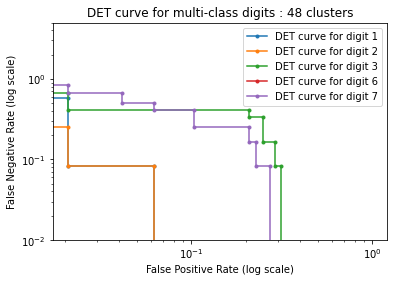

In [117]:
#acc = accModel(count.astype(int))
acc = accModel()
print(acc)

In [118]:
files.download("DET 48 clusters.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(title)
    #plt.show()

    return None

In [ ]:
                                    #Plotting confusion matrices
truedigit = array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
preddigit = array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 1, 0, 1, 1, 1, 1, 1, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
cm = confusion_matrix(truedigit, preddigit)
print(shape(cm))
cm_display = plot_confusion_matrix(cm,target_names=["1","2","3","6","7"],title="Confusion matrix 16 clusters")

preddigit = array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4])
cm = confusion_matrix(truedigit, preddigit)
print(shape(cm))
cm_display = plot_confusion_matrix(cm,target_names=["1","2","3","6","7"],title="Confusion matrix 18 clusters")

preddigit = array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4])
cm = confusion_matrix(truedigit, preddigit)
print(shape(cm))
cm_display = plot_confusion_matrix(cm,target_names=["1","2","3","6","7"],title="Confusion matrix 20 clusters")

preddigit = array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4])
cm = confusion_matrix(truedigit, preddigit)
print(shape(cm))
cm_display = plot_confusion_matrix(cm,target_names=["1","2","3","6","7"],title="Confusion matrix 48 clusters")
#cm_display = ConfusionMatrixDisplay(cm,display_labels=["1","2","3","6","7"]).plot()

                                    #Accuracy plot variation over cluster no.
Ncluster = array([16,18,20,48])
clustacc = array([93.33,95,95,98.33])

plt.plot(Ncluster,clustacc,marker="o")
plt.grid()
plt.title("No. of clusters vs Accuracy")
plt.show()

In [69]:
files.download("Confusion matrix 16 clusters.png")
files.download("Confusion matrix 18 clusters.png")
files.download("Confusion matrix 20 clusters.png")
files.download("Confusion matrix 48 clusters.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Continuous HMMs**

In [ ]:

!cp -avr /content/gdrive/My\ Drive/one.seq.hmm /root
!cp -avr /content/gdrive/My\ Drive/two.seq.hmm /root
!cp -avr /content/gdrive/My\ Drive/three.seq.hmm /root
!cp -avr /content/gdrive/My\ Drive/six.seq.hmm /root
!cp -avr /content/gdrive/My\ Drive/seven.seq.hmm /root
#!cp -avr /content/gdrive/My\ Drive/12.hmm /root
!ls

'/content/gdrive/My Drive/one.seq.hmm' -> '/root/one.seq.hmm'
'/content/gdrive/My Drive/two.seq.hmm' -> '/root/two.seq.hmm'
'/content/gdrive/My Drive/three.seq.hmm' -> '/root/three.seq.hmm'
'/content/gdrive/My Drive/six.seq.hmm' -> '/root/six.seq.hmm'
'/content/gdrive/My Drive/seven.seq.hmm' -> '/root/seven.seq.hmm'
1  cenKM.pkl	  DHMM.test  fp7.txt	    six.seq	   two.seq.hmm
2  ctsHMM	  fp1.txt    one.seq	    six.seq.hmm
3  ctsHMM.dev	  fp2.txt    one.seq.hmm    three.seq
6  ctsModels	  fp3.txt    seven.seq	    three.seq.hmm
7  ctsModels.zip  fp6.txt    seven.seq.hmm  two.seq


In [ ]:
                                    #Concatanate 2-digit models
def filecombine(file1,file2,fileNew,folder="ctsModels",Nstate="10",p=0.85,check=[]) :
                                    #Read file1 - on top
    data1 = np.genfromtxt(file1,delimiter='\n',dtype=str)
                                    #Change the number of states
    headers = np.genfromtxt(data1[:2],delimiter=' ',dtype=str)
    headers[0,1] = Nstate
    headers = list(headers)
    headers.append("\n")
                                    #Read the initial probabilities
    probs1 = np.genfromtxt(data1[2:],delimiter='\t',dtype=str)
    #probs1 = probs1[:,:-1]
    probs1 = probs1.astype("float")
    probs1[-2][0] = 1-p
    probs1[-1][0] = p
                                    #Read file2 - bottom
    data2 = np.genfromtxt(file2,delimiter='\n',dtype=str)
                                    #Read the initial probabilities
    probs2 = np.genfromtxt(data2[2:],delimiter='\t',dtype=str)
    #probs2 = probs2[:,:-1]
    probs2 = probs2.astype("float")
    print(shape(probs1),shape(probs2))
                                    #Change the last state transition probabilities
    probs = np.concatenate((probs1,probs2))
    
                                    #Write to file
    with open(fileNew,"w") as f:
        f.write("\n".join(" ".join(map(str, line)) for line in headers))

    f = open(fileNew,'ab')
    np.savetxt(f,probs,delimiter='\t', fmt='%f')
    !mv $fileNew /root/$folder
    f.close()

    return None

In [ ]:
def digit2model(files=None,folder="ctsModels") :
    if files is None :
        files = ["one.seq.hmm","two.seq.hmm","three.seq.hmm","six.seq.hmm","seven.seq.hmm"]
    opfiles = array([11,12,13,16,17,21,22,23,26,27,31,32,33,36,37,61,62,63,66,67,71,72,73,76,77])
    opfiles = opfiles.astype("str")
    for i in range(0,5) :
        for j in range(0,5) :
            filecombine(files[i],files[j],opfiles[int(5*i+j)]+".hmm")

    return None

In [ ]:
!mkdir ctsModels
digit2model()
# model2digit = array([11,12,13,16,17,21,22,23,26,27,31,32,33,36,37,61,62,63,66,67,71,72,73,76,77])
# model2digit = model2digit.astype("str")
# for i in range(20,25) :
#     files.download(model2digit[i]+".hmm")

(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)
(10, 49) (10, 49)


In [ ]:
!ls
%cd /root/ctsModels/
#!cp *.hmm /root
!ls
%cd

1	21.hmm	32.hmm	63.hmm	76.hmm	   fp2.txt	seven.seq.hmm
11.hmm	22.hmm	33.hmm	66.hmm	77.hmm	   fp3.txt	six.seq
12.hmm	23.hmm	36.hmm	67.hmm	cenKM.pkl  fp6.txt	six.seq.hmm
13.hmm	26.hmm	37.hmm	7	ctsHMM	   fp7.txt	three.seq
16.hmm	27.hmm	6	71.hmm	ctsModels  one.seq	three.seq.hmm
17.hmm	3	61.hmm	72.hmm	DHMM.test  one.seq.hmm	two.seq
2	31.hmm	62.hmm	73.hmm	fp1.txt    seven.seq	two.seq.hmm
/root/ctsModels
111.hmm  13.hmm   217.hmm  266.hmm  323.hmm  372.hmm  631.hmm  67.hmm	737.hmm
112.hmm  161.hmm  21.hmm   267.hmm  326.hmm  373.hmm  632.hmm  711.hmm	73.hmm
113.hmm  162.hmm  221.hmm  26.hmm   327.hmm  376.hmm  633.hmm  712.hmm	761.hmm
116.hmm  163.hmm  222.hmm  271.hmm  32.hmm   377.hmm  636.hmm  713.hmm	762.hmm
117.hmm  166.hmm  223.hmm  272.hmm  331.hmm  37.hmm   637.hmm  716.hmm	763.hmm
11.hmm	 167.hmm  226.hmm  273.hmm  332.hmm  611.hmm  63.hmm   717.hmm	766.hmm
121.hmm  16.hmm   227.hmm  276.hmm  333.hmm  612.hmm  661.hmm  71.hmm	767.hmm
122.hmm  171.hmm  22.hmm   277.hmm  336.hmm  613.h

In [ ]:
def digit3model(files1=None,files2=None,folder="ctsModels") :
    if files1 is None :
        files1 = array([11,12,13,16,17,21,22,23,26,27,31,32,33,36,37,61,62,63,66,67,71,72,73,76,77])
        files1 = files1.astype("str")
    if files2 is None :
        files2 = array([1,2,3,6,7])
        files2 = files2.astype("str")
        files = ["one.seq.hmm","two.seq.hmm","three.seq.hmm","six.seq.hmm","seven.seq.hmm"]
    opfiles = array([11,12,13,16,17,21,22,23,26,27,31,32,33,36,37,61,62,63,66,67,71,72,73,76,77])
    opfiles = opfiles.astype("str")
    for i in range(0,25) :
        for j in range(0,5) :
            filecombine(files1[i]+".hmm",files[j],files1[i]+files2[j]+".hmm",Nstate="15")

    return None

In [ ]:
digit3model()

(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (10, 49)
(20, 49) (

In [ ]:
!zip -r /root/ctsModels.zip /root/ctsModels

files.download("/root/ctsModels.zip")

  adding: root/ctsModels/ (stored 0%)
  adding: root/ctsModels/613.hmm (deflated 85%)
  adding: root/ctsModels/12.hmm (deflated 86%)
  adding: root/ctsModels/137.hmm (deflated 86%)
  adding: root/ctsModels/662.hmm (deflated 89%)
  adding: root/ctsModels/766.hmm (deflated 89%)
  adding: root/ctsModels/162.hmm (deflated 86%)
  adding: root/ctsModels/313.hmm (deflated 89%)
  adding: root/ctsModels/61.hmm (deflated 85%)
  adding: root/ctsModels/672.hmm (deflated 86%)
  adding: root/ctsModels/716.hmm (deflated 86%)
  adding: root/ctsModels/767.hmm (deflated 89%)
  adding: root/ctsModels/76.hmm (deflated 85%)
  adding: root/ctsModels/627.hmm (deflated 86%)
  adding: root/ctsModels/176.hmm (deflated 86%)
  adding: root/ctsModels/316.hmm (deflated 85%)
  adding: root/ctsModels/317.hmm (deflated 86%)
  adding: root/ctsModels/617.hmm (deflated 86%)
  adding: root/ctsModels/621.hmm (deflated 86%)
  adding: root/ctsModels/731.hmm (deflated 86%)
  adding: root/ctsModels/362.hmm (deflated 85%)
  add

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
                                    #Give the file with sequences for cts. dev data
def ctsdevSeq(trainKM,fileWord="check.txt") :
    seq = []   
                                    #Go through required folders
    for subdir, dirs, files in os.walk("ctsHMM"):
        print(subdir)
        dirname = subdir.split(os.path.sep)[-1]
        print('Directory:', dirname)
        if dirname == "dev":
            for f in files:
                if f.endswith(".mfcc"):
                                    #Copy file (mfcc) to root and perform K-means
                    !cp -avr /root/ctsHMM/dev/$f /root
                    label = testKmeans(f,trainKM)
                    seq.append(label)
                    !rm $f

    seq = array(seq)
    
    seqDwnld(seq,fileWord)

    return None

In [ ]:
                                    #Get the test sequence
ctsdevSeq(cenKM,"ctsHMM.dev")

ctsHMM
Directory: ctsHMM
ctsHMM/test
Directory: test
ctsHMM/dev
Directory: dev
'/root/ctsHMM/dev/262.mfcc' -> '/root/262.mfcc'
'/root/ctsHMM/dev/662.mfcc' -> '/root/662.mfcc'
'/root/ctsHMM/dev/66.mfcc' -> '/root/66.mfcc'
'/root/ctsHMM/dev/711.mfcc' -> '/root/711.mfcc'
'/root/ctsHMM/dev/12.mfcc' -> '/root/12.mfcc'
'/root/ctsHMM/dev/233.mfcc' -> '/root/233.mfcc'
'/root/ctsHMM/dev/217.mfcc' -> '/root/217.mfcc'
'/root/ctsHMM/dev/121.mfcc' -> '/root/121.mfcc'
'/root/ctsHMM/dev/622.mfcc' -> '/root/622.mfcc'
'/root/ctsHMM/dev/61.mfcc' -> '/root/61.mfcc'
'/root/ctsHMM/dev/11.mfcc' -> '/root/11.mfcc'
'/root/ctsHMM/dev/13.mfcc' -> '/root/13.mfcc'
'/root/ctsHMM/dev/122.mfcc' -> '/root/122.mfcc'
'/root/ctsHMM/dev/22.mfcc' -> '/root/22.mfcc'
'/root/ctsHMM/dev/111.mfcc' -> '/root/111.mfcc'
'/root/ctsHMM/dev/77.mfcc' -> '/root/77.mfcc'
'/root/ctsHMM/dev/277.mfcc' -> '/root/277.mfcc'
'/root/ctsHMM/dev/212.mfcc' -> '/root/212.mfcc'
'/root/ctsHMM/dev/16.mfcc' -> '/root/16.mfcc'
'/root/ctsHMM/dev/331.mfc

In [ ]:
                                    #Download the test sequence files
files.download("ctsHMM.dev")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
                                    #Give the file with sequences for cts. dev data
def ctstestSeq(trainKM,fileWord="check.txt") :
    seq = []   
                                    #Go through required folders
    for subdir, dirs, files in os.walk("ctsHMM"):
        print(subdir)
        dirname = subdir.split(os.path.sep)[-1]
        print('Directory:', dirname)
        if dirname == "test":
            for f in files:
                if f.endswith(".mfcc"):
                                    #Copy file (mfcc) to root and perform K-means
                    !cp -avr /root/ctsHMM/test/$f /root
                    label = testKmeans(f,trainKM)
                    seq.append(label)
                    !rm $f

    seq = array(seq)
    
    seqDwnld(seq,fileWord)

    return None

In [50]:
                                    #Get the test sequence
ctstestSeq(cenKM,"ctsHMM.test")

ctsHMM
Directory: ctsHMM
ctsHMM/test
Directory: test
'/root/ctsHMM/test/3.mfcc' -> '/root/3.mfcc'
'/root/ctsHMM/test/1.mfcc' -> '/root/1.mfcc'
'/root/ctsHMM/test/4.mfcc' -> '/root/4.mfcc'
'/root/ctsHMM/test/2.mfcc' -> '/root/2.mfcc'
'/root/ctsHMM/test/5.mfcc' -> '/root/5.mfcc'
ctsHMM/dev
Directory: dev


In [51]:
                                    #Download the test sequence files
files.download("ctsHMM.test")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls
%cd ctsHMM/dev
!ls
%cd

1	22.hmm	36.hmm	7	    ctsModels	   one.seq	  two.seq
11.hmm	23.hmm	37.hmm	71.hmm	    ctsModels.zip  one.seq.hmm	  two.seq.hmm
12.hmm	26.hmm	6	72.hmm	    DHMM.test	   seven.seq
13.hmm	27.hmm	61.hmm	73.hmm	    fp1.txt	   seven.seq.hmm
16.hmm	3	62.hmm	76.hmm	    fp2.txt	   six.seq
17.hmm	31.hmm	63.hmm	77.hmm	    fp3.txt	   six.seq.hmm
2	32.hmm	66.hmm	ctsHMM	    fp6.txt	   three.seq
21.hmm	33.hmm	67.hmm	ctsHMM.dev  fp7.txt	   three.seq.hmm
/root/ctsHMM/dev
111.mfcc  122.mfcc  16.mfcc   21.mfcc	262.mfcc  322.mfcc  662.mfcc  77.mfcc
116.mfcc  12.mfcc   172.mfcc  22.mfcc	277.mfcc  331.mfcc  66.mfcc
11.mfcc   132.mfcc  212.mfcc  233.mfcc	311.mfcc  61.mfcc   711.mfcc
121.mfcc  13.mfcc   217.mfcc  23.mfcc	31.mfcc   622.mfcc  71.mfcc
/root


In [ ]:
                                    #Dump K-Means model file
dump(cenKM, open('cenKM.pkl', 'wb'))
files.download("/root/cenKM.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
                                    #Test if dump-load pkl works
!cp -avr /root/7/dev/ra_7.mfcc /root
filex = "ra_7.mfcc"
label,ft = fileTofeature(filex)
true = cenKM.predict(ft)
pklcheck = cenCheck.predict(ft)
print(true==pklcheck)

'/root/7/dev/ra_7.mfcc' -> '/root/ra_7.mfcc'
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]


In [ ]:
                                    #Get the list of all model names
a = array([11,12,13,16,17,21,22,23,26,27,31,32,33,36,37,61,62,63,66,67,71,72,73,76,77])
b = array([1,2,3,6,7])
a = a.astype("str")
b = b.astype("str")
c = np.zeros(125)
for i in range(0,25) :
    for j in range(0,5) :
        c[int(5*i+j)] = a[i]+b[j]

c = c.astype("int")
c = c.astype("str")
c = list(c)
a = list(a)
d = a+c
print(d)

['11', '12', '13', '16', '17', '21', '22', '23', '26', '27', '31', '32', '33', '36', '37', '61', '62', '63', '66', '67', '71', '72', '73', '76', '77', '111', '112', '113', '116', '117', '121', '122', '123', '126', '127', '131', '132', '133', '136', '137', '161', '162', '163', '166', '167', '171', '172', '173', '176', '177', '211', '212', '213', '216', '217', '221', '222', '223', '226', '227', '231', '232', '233', '236', '237', '261', '262', '263', '266', '267', '271', '272', '273', '276', '277', '311', '312', '313', '316', '317', '321', '322', '323', '326', '327', '331', '332', '333', '336', '337', '361', '362', '363', '366', '367', '371', '372', '373', '376', '377', '611', '612', '613', '616', '617', '621', '622', '623', '626', '627', '631', '632', '633', '636', '637', '661', '662', '663', '666', '667', '671', '672', '673', '676', '677', '711', '712', '713', '716', '717', '721', '722', '723', '726', '727', '731', '732', '733', '736', '737', '761', '762', '763', '766', '767', '771', '7

In [ ]:
%cd /root/ctsModels/
!rm *.hmm
!ls
%cd
!rmdir /root/ctsModels/
!rm /root/ctsModels.zip
!rm ctsHMM.dev
!ls

/root/ctsModels
/root
1  7	      fp1.txt  fp7.txt	    seven.seq.hmm  three.seq.hmm
2  cenKM.pkl  fp2.txt  one.seq	    six.seq	   two.seq
3  ctsHMM     fp3.txt  one.seq.hmm  six.seq.hmm    two.seq.hmm
6  DHMM.test  fp6.txt  seven.seq    three.seq


In [ ]:
!ls

1  6	      ctsHMM	  ctsModels.zip  fp2.txt  fp7.txt    six.seq
2  7	      ctsHMM.dev  DHMM.test	 fp3.txt  one.seq    three.seq
3  cenKM.pkl  ctsModels   fp1.txt	 fp6.txt  seven.seq  two.seq
